# ML Algorithms for Handwritten Digits Classification

In this notebook, the effectiveness of five classification-based machine learning algorithms: K-Nearest Neighbours, Decision Trees, Logistic Regression, Support Vector Machines, and Random Forest are evaluated with the aim of identifying the most effective algorithm for classifying handwritten digits.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score


## Load Digits dataset

The digits dataset from `sklearn.datasets` will be used in this project.


In [2]:
digits = datasets.load_digits(as_frame=True)

# extract features X and target y
X, y = digits.data, digits.target

## Exploratory Data Analysis

The dataset contains 1,797 samples, each representing a handwritten digit image. Each sample has 64 features, which corresponds to the pixel values in a 8x8 grid that makes up each image. There are a total of 1,797 labels where each label is a number from 0 to 9. Each label indicates the digit that the corresponding handwritten image represents.


In [3]:
print(f"Data shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Unique classes: {y.unique()}")

Data shape: (1797, 64)
Target shape: (1797,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]


All 64 features has a count of 1797, indicating that there are no missing values. This also suggests that the use of k-Fold cross-validation would be an appropriate method for evaluating the ML models.


In [4]:
X.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


Below is a plot of the first 10 samples along with their corresponding label. It shows how each image is made up of an 8x8 grid of pixel values, and how each label corresponds to the handwritten digit.


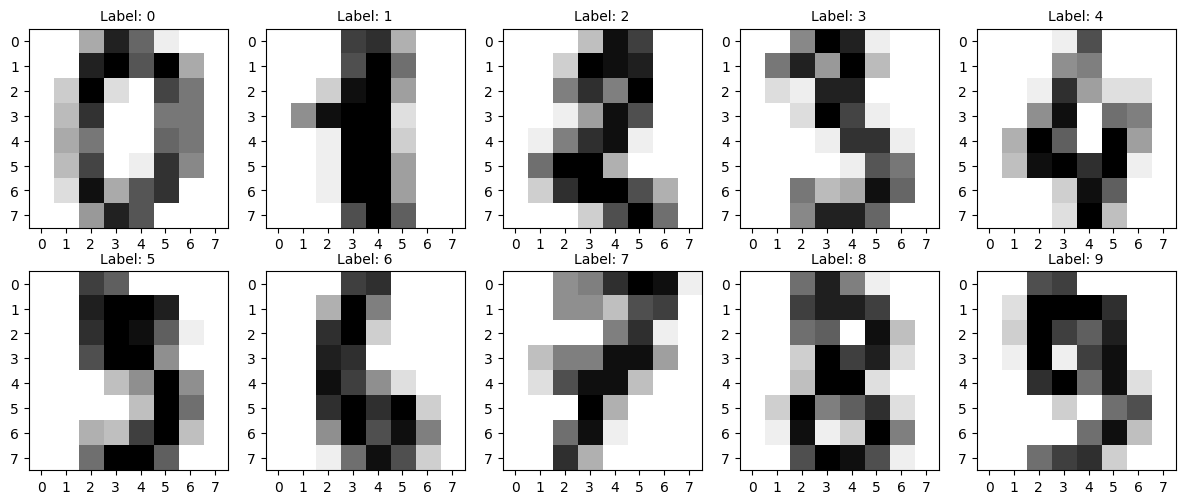

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 5))
axes = axes.flatten()

for ax, image, label in zip(axes, X.values, y):
    ax.imshow(image.reshape(8, 8), cmap="gray_r")
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_title(f"Label: {label}", fontsize=10)

plt.tight_layout()
plt.show()

### Class Distribution

The plot below shows that the distribution across all 10 classes are relatively balanced, with each digit represented by 174 to 183 samples. This ensures that each of the classes are equally represented, which can lead to better generalization and more reliable performance metrics.

This balanced dataset also suggests that accuracy would be a good metric for evaluating each ML model's performance.


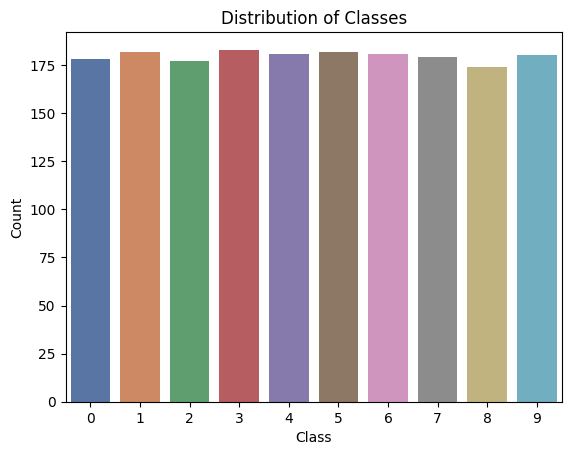

In [6]:
# plot distribution of classes
sns.countplot(x=y, hue=y, palette="deep", legend=False).set_title(
    "Distribution of Classes"
)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Data Pre-Processing


### Train test split

In order to prepare the digits data to be suitable for training and evaluating the machine learning models, the data will first be split into training and testing sets so that the models can be evaluated on unseen data (test set) after it is trained on the training data.

Splitting will be done in the ratio `20:80`, **20% of testing data** and **80% of training data**.

-   `X_train`: training data, `X_test`: test data

-   `y_train`: training labels, `y_test`: test labels


In [7]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# keep a copy for displaying images later
X_train_copy = X_train.values
X_test_copy = X_test.values


len(X_train), len(X_test), len(y_train), len(y_test)

(1437, 360, 1437, 360)

### Feature scaling

Feature scaling will be carried so that feature values contribute equally to the model's performance.


In [8]:
scaler = StandardScaler()

# only fit on training data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# convert to np ndarray
y_train = y_train.values
y_test = y_test.values

type(X_train), type(y_train), type(X_test), type(y_test)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

## Implementation of K-Nearest Neighbors (from scratch)

The `myKNN` class below is my own implementation of the K-Nearest Neighbors algorithm from scratch.


In [10]:
class myKNN:
    """
    K-Nearest Neighbors algorithm for classification.
    """

    def __init__(self, k=5, dist_metric="euclidean"):
        """
        Initialize the KNN classifier with k neighbors and distance metric to use.
        By default, k is 5 and Euclidean distance is used.
        """
        self.k = k
        self.dist_metric = dist_metric

    def fit(self, X_train, y_train):
        """Fit the model using X_train as training data and y_train as target values."""
        if len(X_train) != len(y_train):
            raise ValueError("Length of X_train and y_train must be equal")
        self.X_train = X_train
        self.y_train = y_train

    def compute_distance(self, x1, x2):
        """Compute the distance between two data points using the distance metric specified."""
        if self.dist_metric == "euclidean":
            return np.sqrt(np.sum((x1 - x2) ** 2, axis=1))
        elif self.dist_metric == "manhattan":
            return np.sum(np.abs(x1 - x2), axis=1)
        elif self.dist_metric == "cosine":
            dot_product = np.dot(x1, x2)
            norm_x1 = np.linalg.norm(x1)
            norm_x2 = np.linalg.norm(x2)
            cosine_similarity = dot_product / (norm_x1 * norm_x2)
            return 1 - cosine_similarity
        else:
            raise ValueError(f"Unknown distance metric: {self.dist_metric}")

    def predict(self, X_test):
        """Predict the class labels for the provided data."""
        predictions = []
        for x in X_test:
            # compute distances using the specified distance metric
            dists = self.compute_distance(self.X_train, x)

            # get the k nearest neighbors & labels
            nearest_idx = np.argsort(dists)[: self.k]
            nearest_labels = [self.y_train[i] for i in nearest_idx]

            # use label with highest frequency as prediction
            predictions.append(np.bincount(nearest_labels).argmax())
        return predictions

    def set_params(self, **params):
        """Set the parameters for current instance."""
        for param, value in params.items():
            setattr(self, param, value)
        return self

**Verify implementation**

Below I have initialised both my own KNN and sklearn's KNN to verify if my implementation works as expected. Using the same configuration of k=5 and "euclidean" distance, both classifiers produced the same predictions and accuracy, allowing me to confirm that my implementation works correctly.


In [11]:
knn = myKNN(k=5, dist_metric="euclidean")
knn.fit(X_train, y_train)

predicted = knn.predict(X_test)

print(predicted[:10])
print(f"Accuracy: {accuracy_score(y_test, predicted):.4f}")

[6, 9, 3, 7, 2, 1, 5, 2, 5, 2]
Accuracy: 0.9750


In [12]:
# !! sklearn's KNeighborsClassifier only imported for verification purposes !!
from sklearn.neighbors import KNeighborsClassifier

sklearn_knn = KNeighborsClassifier(n_neighbors=5, metric="euclidean")
sklearn_knn.fit(X_train, y_train)

sklearn_predicted = sklearn_knn.predict(X_test)

print(sklearn_predicted[:10])
print(f"Accuracy: {accuracy_score(y_test, sklearn_predicted):.4f}")

[6 9 3 7 2 1 5 2 5 2]
Accuracy: 0.9750


## Hyperparameter tuning


In [13]:
def tune_hyperparam(X, y, model, params, k_folds=5):
    """
    Perform hyperparameter tuning using grid search with k-fold cross-validation.
    Returns the best hyperparameters and score.
    """
    grid_search = GridSearchCV(
        model, params, cv=k_folds, scoring="accuracy", return_train_score=True
    )
    grid_search.fit(X, y)

    # get best hyperparams & score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score


def tune_KNN(X, y, knn_model, params, k_folds=5):
    """
    Finds the optimal k and distance metric for the KNN model using k-fold cross validation.
    (only used for myKNN model)
    """
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    best_params = {
        "best_k": None,
        "best_metric": None,
        "avg_accuracy": 0,
    }

    # iterate through all k and metric combinations
    for dist in params["dist_metric"]:
        for k in params["k"]:
            fold_accuracies = []
            # perform k-fold cross validation
            for train_idx, test_idx in kfold.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                knn_model.set_params(k=k, dist_metric=dist)
                knn_model.fit(X_train, y_train)
                y_pred = knn_model.predict(X_test)

                accuracy = np.mean(y_pred == y_test)
                fold_accuracies.append(accuracy)

            # get the average accuracy across all folds
            avg_accuracy = np.mean(fold_accuracies)

            # store the combination with best average accuracy
            if avg_accuracy > best_params["avg_accuracy"]:
                best_params["best_k"] = k
                best_params["best_metric"] = dist
                best_params["avg_accuracy"] = avg_accuracy
    return best_params

### K-Nearest Neighbours

For KNN, the best combination of K value and distance metric will be identified.


In [14]:
# KNN hyperparameters to tune
knn_params = {
    "k": list(range(1, 21)),
    "dist_metric": [
        "euclidean",
        "manhattan",
        "cosine",
    ],
}

best_knn_params = tune_KNN(X_train, y_train, myKNN(), knn_params, k_folds=5)

print(
    f"Best hyperparameters for myKNN:\n"
    f"  >> k = {best_knn_params['best_k']}\n"
    f"  >> Distance Metric = {best_knn_params['best_metric']}\n"
    f"Average Accuracy = {best_knn_params['avg_accuracy']:.2%}"
)

Best hyperparameters for myKNN:
  >> k = 1
  >> Distance Metric = manhattan
Average Accuracy = 97.50%


### Decision Trees


In [15]:
# hyperparameters to test
dtree_params = {
    "criterion": ["gini", "entropy"],
    "max_depth": [3, 5, 10, 15, 20, None],
    "min_samples_split": [2, 3, 5, 10],
    "min_samples_leaf": [1, 3, 5, 10],
}

best_dtree_params, best_dtree_score = tune_hyperparam(
    X_train, y_train, DecisionTreeClassifier(random_state=42), dtree_params, k_folds=5
)

print(
    f"Best hyperparameters for Decision Tree:\n"
    f"  >> criterion = {best_dtree_params['criterion']}\n"
    f"  >> max_depth = {best_dtree_params['max_depth']}\n"
    f"  >> min_samples_split = {best_dtree_params['min_samples_split']}\n"
    f"  >> min_samples_leaf = {best_dtree_params['min_samples_leaf']}\n"
    f"Average Accuracy = {best_dtree_score:.2%}"
)

Best hyperparameters for Decision Tree:
  >> criterion = entropy
  >> max_depth = 15
  >> min_samples_split = 2
  >> min_samples_leaf = 1
Average Accuracy = 85.94%


### Logistic Regression


In [16]:
lr_params = {
    "C": np.logspace(-4, 4, 50),
}

best_lr_params, best_lr_score = tune_hyperparam(
    X_train,
    y_train,
    LogisticRegression(max_iter=3000, random_state=42),
    lr_params,
    k_folds=5,
)

print(
    f"Best hyperparameters for Logistic Regression:\n"
    f"  >> C = {best_lr_params['C']}\n"
    f"Average Accuracy = {best_lr_score:.2%}"
)

Best hyperparameters for Logistic Regression:
  >> C = 0.2682695795279725
Average Accuracy = 96.52%


### Support Vector Machine


In [17]:
svm_params = {
    "C": [0.1, 1, 10, 100, 500],
    "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
    "kernel": ["linear", "rbf", "sigmoid"],
}

best_svm_params, best_svm_score = tune_hyperparam(
    X_train, y_train, SVC(random_state=42), svm_params, k_folds=5
)

print(
    f"Best hyperparameters for SVM:\n"
    f"  >> C = {best_svm_params['C']}\n"
    f"  >> gamma = {best_svm_params['gamma']}\n"
    f" >> kernel = {best_svm_params['kernel']}\n"
    f"Average Accuracy = {best_svm_score:.2%}"
)

Best hyperparameters for SVM:
  >> C = 100
  >> gamma = 0.01
 >> kernel = rbf
Average Accuracy = 98.12%


### Random Forest


In [18]:
rf_params = {
    "n_estimators": [25, 100, 200],
    "max_depth": [None, 10, 50, 100],
    "min_samples_split": [2, 5, 10],
}

best_rf_params, best_rf_score = tune_hyperparam(
    X_train, y_train, RandomForestClassifier(random_state=42), rf_params, k_folds=5
)

print(
    f"Best hyperparameters for Random Forest:\n"
    f"  >> n_estimators = {best_rf_params['n_estimators']}\n"
    f"  >> max_depth = {best_rf_params['max_depth']}\n"
    f"  >> min_samples_split = {best_rf_params['min_samples_split']}\n"
    f"Average Accuracy = {best_rf_score:.2%}"
)

Best hyperparameters for Random Forest:
  >> n_estimators = 100
  >> max_depth = None
  >> min_samples_split = 2
Average Accuracy = 97.49%


### Summary of best hyperparameters


In [19]:
# show the best hyperparameters for each model nicely
best_params = {
    "KNN": best_knn_params,
    "Decision Tree": best_dtree_params,
    "Logistic Regression": best_lr_params,
    "SVM": best_svm_params,
    "Random Forest": best_rf_params,
}

for model, params in best_params.items():
    print(f"Best hyperparameters for {model}:")
    for param, value in params.items():
        print(f"  >> {param} = {value}")
    print()

Best hyperparameters for KNN:
  >> best_k = 1
  >> best_metric = manhattan
  >> avg_accuracy = 0.9749540263259776

Best hyperparameters for Decision Tree:
  >> criterion = entropy
  >> max_depth = 15
  >> min_samples_leaf = 1
  >> min_samples_split = 2

Best hyperparameters for Logistic Regression:
  >> C = 0.2682695795279725

Best hyperparameters for SVM:
  >> C = 100
  >> gamma = 0.01
  >> kernel = rbf

Best hyperparameters for Random Forest:
  >> max_depth = None
  >> min_samples_split = 2
  >> n_estimators = 100



## Results

The base algorithms (using default hyperparameters) will first be trained on the training data, then used to predict on the test data. After that, the algorithms will be reinitialized with the most optimal hyperparameters found during hyperparameter tuning, then retrained on the same training data, and used to predict on the same test data.

Comparison of performance will be based on Accuracy, Precision, Recall, and F1-Score.


### Helper Functions


In [20]:
def get_metrics(y_true, y_pred):
    """
    Returns a dictionary of metrics for the predictions.
    """
    return {
        "Accuracy": accuracy_score(y_true, y_pred) * 100,
        "Precision": precision_score(y_true, y_pred, average="macro") * 100,
        "Recall": recall_score(y_true, y_pred, average="macro") * 100,
        "F1-Score": f1_score(y_true, y_pred, average="macro") * 100,
    }


def train_and_eval(models, X_train, y_train, X_test, y_test):
    """
    Train the models on the training data,
    and evaluate their performance on the test data.
    """
    predictions = []
    metrics = []

    # train and predict with tuned models
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions.append(y_pred)
        metrics.append(get_metrics(y_test, y_pred))
    return predictions, metrics


def plot_confusion_matrix(model_name, y_true, y_pred):
    """
    Plots a confusion matrix for the specified model.
    """
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(
        cm,
        index=range(10),
        columns=range(10),
    )

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d", cmap="flare")
    ax.set_title(f"Confusion Matrix ({model_name})")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.show()


def plot_classified_images(model_name, X_test, y_true, y_pred):
    """
    Plots the first 5 misclassified and correctly classified images.
    """
    misclassified = np.where(y_true != y_pred)[0]
    correctly_classified = np.where(y_true == y_pred)[0]

    plt.figure(figsize=(12, 5))

    # misclassified images
    for i, idx in enumerate(misclassified[:5]):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[idx].reshape(8, 8), cmap="gray_r")
        plt.title(f"Predicted: {y_pred[idx]}\nActual: {y_true[idx]}", fontsize=9)
        plt.xticks([])
        plt.yticks([])

    # correctly classified images
    for i, idx in enumerate(correctly_classified[:5]):
        plt.subplot(2, 5, i + 6)
        plt.imshow(X_test[idx].reshape(8, 8), cmap="gray_r")
        plt.title(f"Predicted: {y_pred[idx]}\nActual: {y_true[idx]}", fontsize=9)
        plt.xticks([])
        plt.yticks([])

    plt.subplots_adjust(hspace=0.4)

    plt.subplot(2, 5, 3)
    plt.xlabel("<-- Misclassified -->", fontsize=10)
    plt.subplot(2, 5, 8)
    plt.xlabel("<-- Correctly Classified -->", fontsize=10)

    plt.suptitle(f"Classified Images ({model_name})", fontsize=13)
    plt.tight_layout()
    plt.show()

Here, 3 lists are created:

1. `base_algos`: A list of models with default parameters.

2. `tuned_algos`: A list of models with the optimised hyperparameters are created.

3. `model_names`: A list of the respective model names.


In [21]:
# algorithms with default hyperparameters
base_algos = [
    myKNN(),
    DecisionTreeClassifier(random_state=42),
    LogisticRegression(max_iter=3000, random_state=42),
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
]

# algorithms with tuned hyperparameters
tuned_algos = [
    myKNN(k=best_knn_params["best_k"], dist_metric=best_knn_params["best_metric"]),
    DecisionTreeClassifier(
        random_state=42,
        criterion=best_dtree_params["criterion"],
        max_depth=best_dtree_params["max_depth"],
        min_samples_split=best_dtree_params["min_samples_split"],
        min_samples_leaf=best_dtree_params["min_samples_leaf"],
    ),
    LogisticRegression(C=best_lr_params["C"], max_iter=3000, random_state=42),
    SVC(
        random_state=42,
        C=best_svm_params["C"],
        gamma=best_svm_params["gamma"],
        kernel=best_svm_params["kernel"],
    ),
    RandomForestClassifier(
        random_state=42,
        n_estimators=best_rf_params["n_estimators"],
        max_depth=best_rf_params["max_depth"],
        min_samples_split=best_rf_params["min_samples_split"],
    ),
]

model_names = [
    "K-Nearest Neighbours",
    "Decision Tree",
    "Logistic Regression",
    "Support Vector Machine",
    "Random Forest",
]

In [22]:
# train and evaluate default models
base_preds, base_metrics = train_and_eval(base_algos, X_train, y_train, X_test, y_test)
base_metrics_df = pd.DataFrame(base_metrics, index=model_names)

# train and evaluate tuned models
tuned_preds, tuned_metrics = train_and_eval(
    tuned_algos, X_train, y_train, X_test, y_test
)
tuned_metrics_df = pd.DataFrame(tuned_metrics, index=model_names)

## Evaluation

Initially, the Decision Tree algorithm had an accuracy of 84%, but after hyperparameter tuning, it improved to 88%. On the other hand, Support Vector Machine, Logistic Regression, K-Nearest Neighbours only showed very minor improvements in all metrics, with Random Forest having the same scores before and after optimisation.

This result suggests that hyperparameter tuning can greatly improve the performance of algorithms like the Decision Tree when it comes to classifying handwritten digits, wheres for algorithms like Random Forest, it does not really make much impact.


In [23]:
print("Results of default algorithms:")
display(base_metrics_df.map(lambda x: f"{x:.2f}%"))

print("Results of optimised algorithms:")
display(tuned_metrics_df.map(lambda x: f"{x:.2f}%"))

Results of default algorithms:


,Accuracy,Precision,Recall,F1-Score
K-Nearest Neighbours,97.50%,97.65%,97.69%,97.65%
Decision Tree,84.17%,84.47%,83.60%,83.85%
Logistic Regression,97.22%,97.37%,97.44%,97.40%
Support Vector Machine,98.06%,98.30%,98.07%,98.17%
Random Forest,97.22%,97.40%,97.27%,97.32%


Results of optimised algorithms:


,Accuracy,Precision,Recall,F1-Score
K-Nearest Neighbours,97.78%,97.82%,97.98%,97.88%
Decision Tree,88.89%,89.16%,88.66%,88.84%
Logistic Regression,97.50%,97.68%,97.69%,97.67%
Support Vector Machine,98.06%,98.08%,98.15%,98.11%
Random Forest,97.22%,97.40%,97.27%,97.32%


## Conclusion

In this notebook, five classification-based machine learning algorithms were evaluated for handwritten digit classification. The results show that the Support Vector Machine (SVM) algorithm surpassed the others, achieving the highest accuracy of 98.06%, and excelling in precision, recall, and F1-score. This indicates its efficiency in both identifying true cases and minimizing false classifications. K-Nearest Neighbours (KNN), Logistic Regression, and Random Forest also showed good performance with accuracies just slightly below SVM. However, the Decision Tree algorithm showed lower metrics, suggesting a trade-off between its simplicity and classification efficacy.

These findings fulfill the project's aim of determining the most efficient algorithm for digit classification, with SVM being the algorithm that is most efficient for this task due to its balanced and high performance across all metrics.


In [24]:
# sort by accuracy
display(
    tuned_metrics_df.sort_values(by="Accuracy", ascending=False).map(
        lambda x: f"{x:.2f}%"
    )
)

,Accuracy,Precision,Recall,F1-Score
Support Vector Machine,98.06%,98.08%,98.15%,98.11%
K-Nearest Neighbours,97.78%,97.82%,97.98%,97.88%
Logistic Regression,97.50%,97.68%,97.69%,97.67%
Random Forest,97.22%,97.40%,97.27%,97.32%
Decision Tree,88.89%,89.16%,88.66%,88.84%


### K-Nearest Neighbours


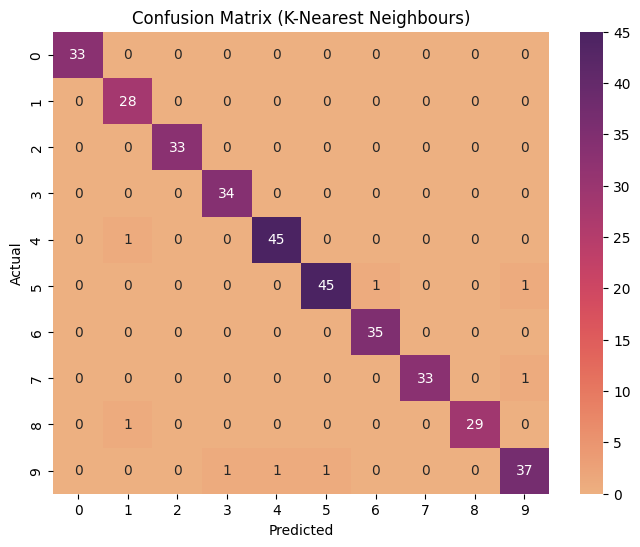

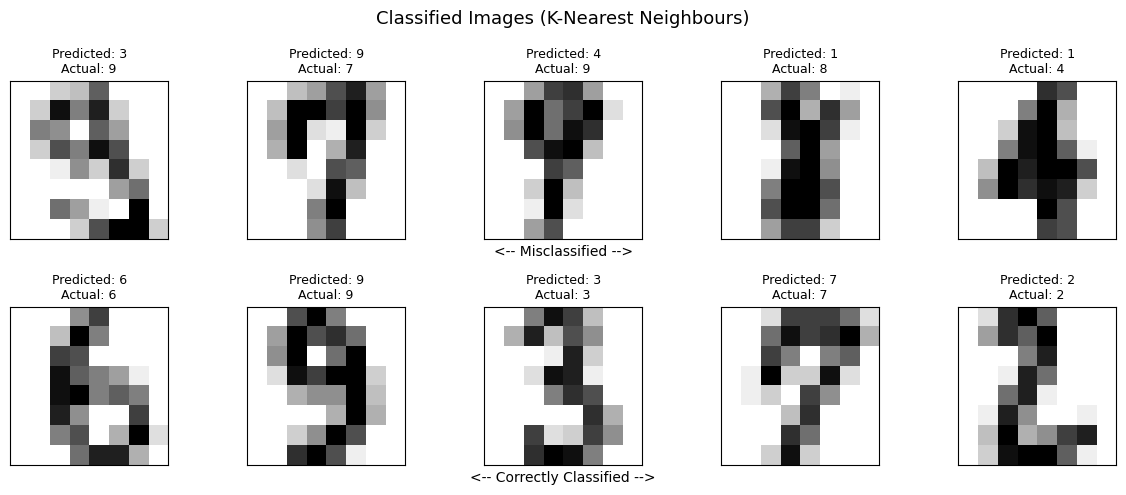

In [25]:
plot_confusion_matrix(model_names[0], y_test, tuned_preds[0])
plot_classified_images(model_names[0], X_test_copy, y_test, tuned_preds[0])

### Decision Tree


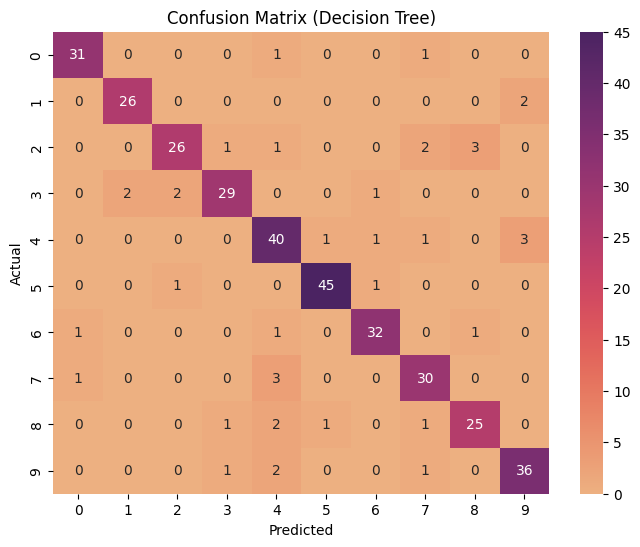

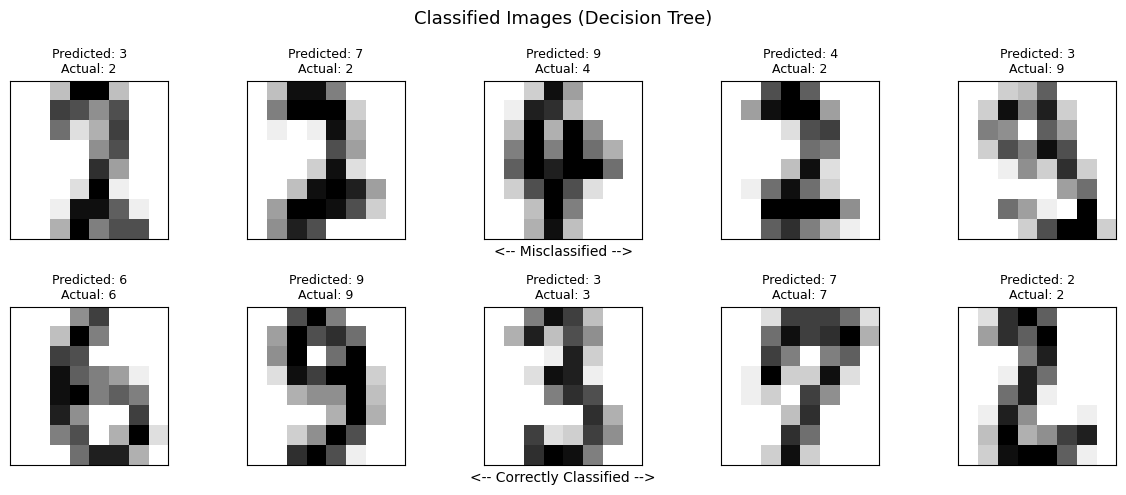

In [26]:
plot_confusion_matrix(model_names[1], y_test, tuned_preds[1])
plot_classified_images(model_names[1], X_test_copy, y_test, tuned_preds[1])

### Logistic Regression


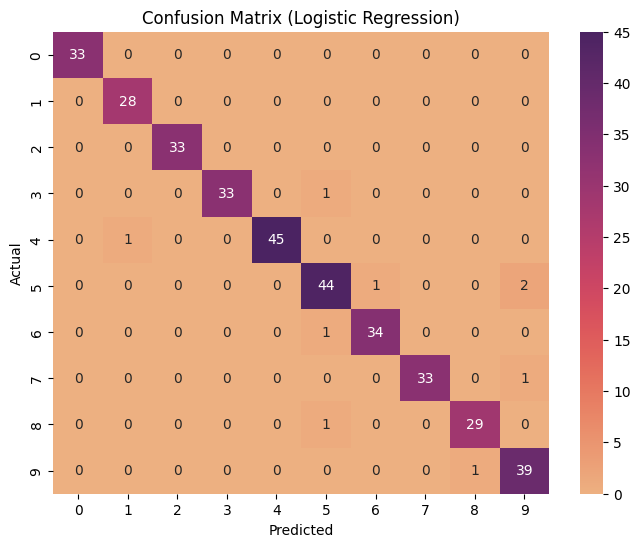

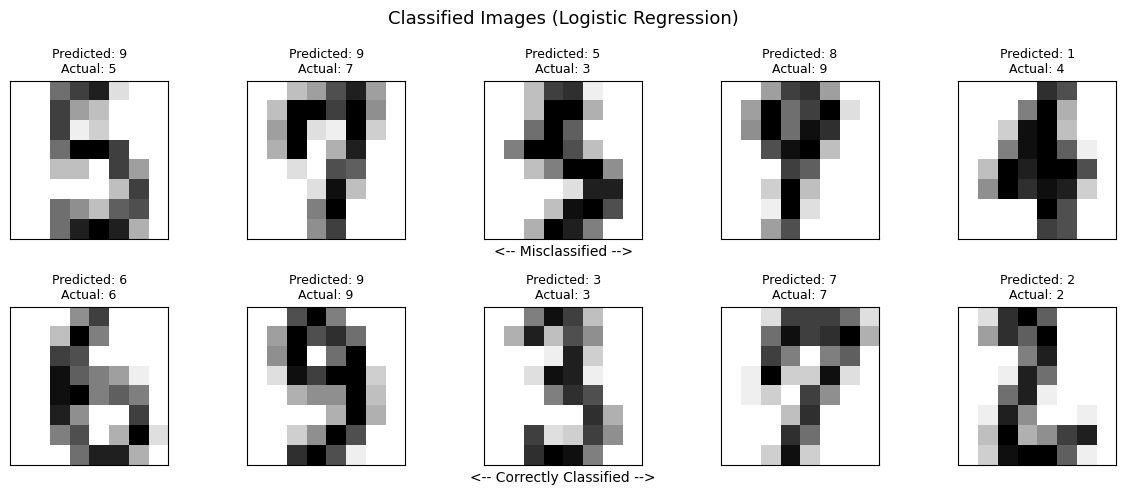

In [27]:
plot_confusion_matrix(model_names[2], y_test, tuned_preds[2])
plot_classified_images(model_names[2], X_test_copy, y_test, tuned_preds[2])

### Support Vector Machine


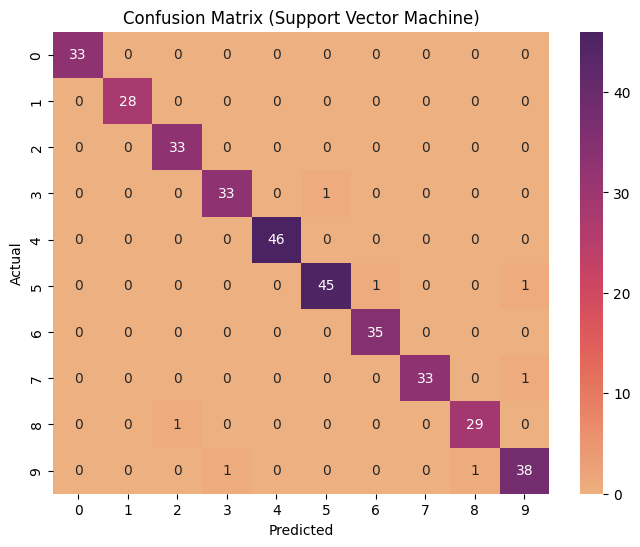

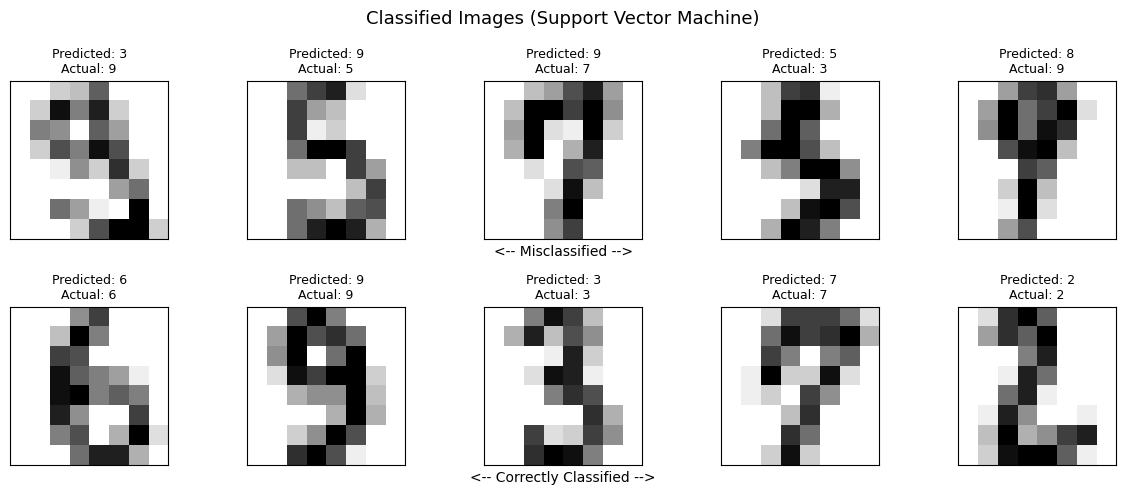

In [28]:
plot_confusion_matrix(model_names[3], y_test, tuned_preds[3])
plot_classified_images(model_names[3], X_test_copy, y_test, tuned_preds[3])

### Random Forest


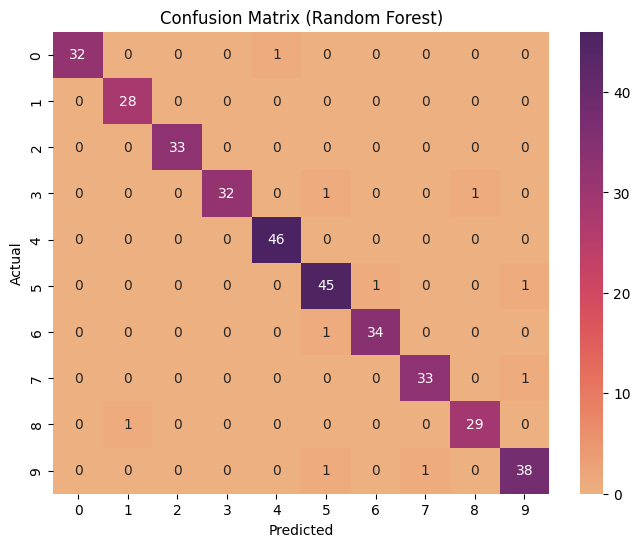

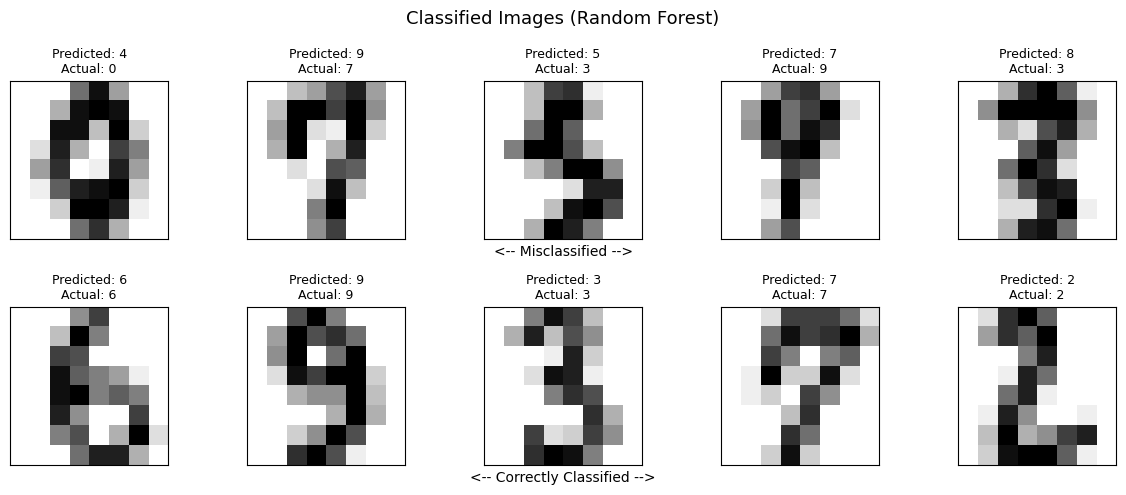

In [29]:
plot_confusion_matrix(model_names[4], y_test, tuned_preds[4])
plot_classified_images(model_names[4], X_test_copy, y_test, tuned_preds[4])